In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import keras as ks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def show_label_preds(true_false, original_images, y_true, y_pred, num_samples=25):
    try:
        y_pred = np.argmax(y_pred, axis=1)
    except Exception as e:
        pass

    if (true_false):
        indices = np.where((y_true == y_pred))[0]
        title = "Correct Preditions"
    else:
        indices = np.where((y_true != y_pred))[0]
        title = "Incorrect Preditions"

    # for n in indices:
    #     print(f"{y_true[n]} : {y_pred[n]}")
    
    if len(indices) > num_samples:
        sample_indices = np.random.choice(indices, num_samples, replace=False)
    else:
        sample_indices = indices
    
    grid_size = int(np.ceil(np.sqrt(len(sample_indices))))
    
    plt.figure(figsize=(20, 20))
    for idx, i in enumerate(sample_indices):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [3]:
def evaluate_individual_models(models, test_imgs, test_labels):
    evals = []
    for i, model in enumerate(models):
        eval = model.evaluate(test_imgs[i::3], test_labels[i::3], verbose=0)
        evals.append(eval)
    return np.array(evals).T

def compute_binary_metrics(predicted_labels_combined, true_labels):
    
    binary_predictions = (predicted_labels_combined == true_labels).astype(int)
    binary_true_labels = np.ones_like(binary_predictions)
    conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

    accuracy = accuracy_score(true_labels, predicted_labels_combined)
    f1 = f1_score(true_labels, predicted_labels_combined, average='macro')
    
    return {
        "confusion_matrix": conf_matrix,
        "accuracy": accuracy,
        "f1_score": f1
    }

def plot_confusion_matrix(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Binary Confusion Matrix for Model Predictions')
    plt.show()

def get_all_stats(models, preds, imgs, labels):
    score = evaluate_individual_models(models, imgs, labels)

    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    # Compute binary metrics
    binary_metrics = compute_binary_metrics(preds, labels)

    # Print metrics
    print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
    print(f"F1 Score (Macro Average): {binary_metrics['f1_score']:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(binary_metrics["confusion_matrix"])


In [4]:
def plot_training_history(history):
    # completed_epochs = len(history.epoch)
    # print(f"Completed epochs: {completed_epochs}")

    # Extract values for plotting
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    # Set up the figure with subplots
    plt.figure(figsize=(16, 10))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.title('Model Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
    plt.title('Model Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [5]:
def get_stats(preds, _test_labels):
    predicted_labels = preds

    true_labels = _test_labels

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute F1 Score (macro-average across classes)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro Average): {f1:.4f}")

    # Correctly predicted = 1, Incorrectly predicted = 0
    binary_predictions = (predicted_labels == true_labels).astype(int)

    # True binary labels
    binary_true_labels = np.ones_like(binary_predictions)  # True labels are all "correct" (1)

    if len(np.unique(np.unique(true_labels))) > 10:

        # Compute confusion matrix
        conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Binary Confusion Matrix for Model Predictions')
        plt.show()
    
    else:
        print(f"# Correct Predictions: {np.sum(binary_predictions)}")
        print(f"# Incorrect Predictions: {len(binary_predictions) - np.sum(binary_predictions)}")


        conf_matrix = confusion_matrix(true_labels, predicted_labels)

        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(true_labels))
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix for Model Predictions')
        plt.show()


In [6]:
def get_stat_history(preds, _test_labels, history):
    # completed_epochs = len(history.epoch)
    # print(f"\nCompleted epochs: {completed_epochs}\n")
    get_stats(preds, _test_labels)
    plot_training_history(history)

In [2]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path)).resize((45, 45))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))



    return np.array(imgs), np.array(labels)


train_imgs, train_labels = flatten_toarray('train')
test_imgs, test_labels = flatten_toarray('test')
val_imgs, val_labels = flatten_toarray('val')

train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0
val_imgs = val_imgs / 255.0

In [3]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L').resize((45,45))
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


t_train_imgs, t_train_labels = splits_flatten_toarray('train')
t_test_imgs, t_test_labels = splits_flatten_toarray('test')
t_val_imgs, t_val_labels = splits_flatten_toarray('val')

t_train_imgs = t_train_imgs / 255.0
t_test_imgs = t_test_imgs / 255.0
t_val_imgs = t_val_imgs / 255.0

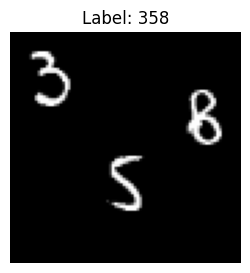

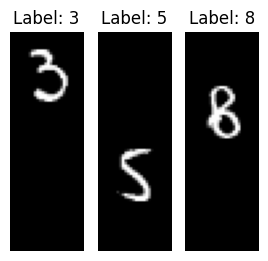

In [7]:
db_sets=['val/','train/','test/']

db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

#select random image and get pathname
img=random.choice(os.listdir(subfolder_path))
test_img_path=os.path.join(subfolder_path, img)

test_img=Image.open(test_img_path).convert('L')

split_width = test_img.size[0] // 3

test_splits= [
    test_img.crop((i * split_width, 0 , (i+1) * split_width, test_img.size[1]))
    for i in range(3)
]

# Plot the original image
plt.figure(figsize=(10,3))
plt.imshow(test_img, cmap='gray')
plt.title(f'Label: {subfolder}')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,4))
for i, split in enumerate(test_splits):
    plt.subplot(1, 9, i+1)
    plt.imshow(test_splits[i], cmap='gray')
    plt.title(f'Label: {subfolder[i]}')
    plt.axis('off')
plt.show()


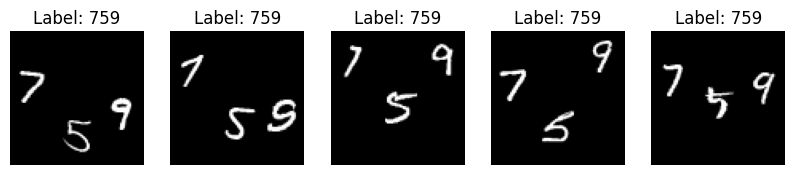

In [38]:
#init images array
imgs=[]
db_sets=['val/','train/','test/']

db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

#select random subfolder and get pathname
subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

for i in range(5):
    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

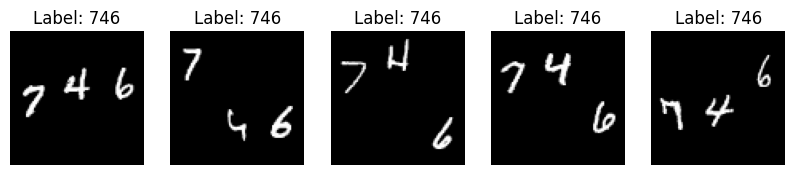

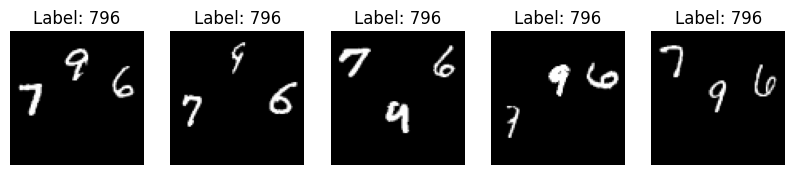

In [37]:
#init images array
imgs=[]
db_sets=['val/','train/','test/']

db_set='val/'

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

#select random subfolder and get pathname
subfolder='746'
subfolder_path = os.path.join(set_path, subfolder)

for i in range(5):
    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

imgs = []
subfolder='796'
subfolder_path = os.path.join(set_path, subfolder)

for i in range(5):
    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

In [5]:
# Convert each number to a string
_t_train_labels = [str(label) for label in t_train_labels]

# Initialize counters for each position
position_counters = [Counter() for _ in range(3)]

# Count digits for each position
for label in _t_train_labels:
    for i, digit in enumerate(label):
        position_counters[i][digit] += 1

# Find the top 3 most common digits for each position
top_3_digits_per_position = [
    counter.most_common(3) for counter in position_counters
]

# Display the results
for i, top_3 in enumerate(top_3_digits_per_position):
    print(f"Top 3 digits for position {i + 1}: {top_3}")

Top 3 digits for position 1: [('7', 20500), ('2', 20500), ('3', 19700)]
Top 3 digits for position 2: []
Top 3 digits for position 3: []


In [10]:
def t_build_cnn_basic():
    t_model = models.Sequential()
    t_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 15, 1)))
    t_model.add(layers.MaxPooling2D((2, 2)))

    t_model.add(layers.Flatten())
    t_model.add(layers.Dropout(0.5))
    t_model.add(layers.Dense(100, activation='relu'))
    t_model.add(layers.Dense(10, activation='softmax'))

    t_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return t_model

In [11]:
def t_build_cnn_comp():
   # CNN Model Architecture (Adjusted Padding)
    t_model2 = models.Sequential()

    # Conv Layer Block 1
    t_model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(45, 15, 1)))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Conv Layer Block 2
    t_model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Conv Layer Block 3
    t_model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Flatten the output of the last convolutional layer
    t_model2.add(layers.Flatten())

    # Fully Connected (Dense) Layer
    t_model2.add(layers.Dense(512, activation='relu'))
    t_model2.add(layers.Dropout(0.5))

    # Output Layer
    t_model2.add(layers.Dense(10, activation='softmax'))  

   #  model2.summary()
    t_model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return t_model2

In [80]:
def t_build_cnn_comp2():
    t_model2 = models.Sequential()

    # Conv Layer Block 1
    t_model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(45, 15, 1)))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.4))  # Increased dropout for stronger regularization

    # Conv Layer Block 2
    t_model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.4))  # Increased dropout

    # Flatten the output of the last convolutional layer
    t_model2.add(layers.Flatten())

    # Fully Connected (Dense) Layer
    t_model2.add(layers.Dense(256, activation='relu'))  # Reduced size
    t_model2.add(layers.Dropout(0.5))  # Keep high dropout for dense layers

    # Output Layer
    t_model2.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    t_model2.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

    return t_model2

In [38]:
t_train_imgs = t_train_imgs[:, :, :, np.newaxis]
t_val_imgs = t_val_imgs[:, :, :, np.newaxis]
t_test_imgs = t_test_imgs[:, :, :, np.newaxis]


print(f"t_train_imgs shape: {t_train_imgs.shape}")
print(f"t_test_imgs shape: {t_val_imgs.shape}")


print(t_train_labels.shape)
print(t_val_labels.shape)

print(len(t_train_labels))

t_train_imgs shape: (192000, 45, 15, 1)
t_test_imgs shape: (48000, 45, 15, 1)
(192000,)
(48000,)
192000


In [14]:
b_t_models = []
b_histories = []
for i in range(3):
    print(f"Training model for digit {i+1}")
    b_t_model = t_build_cnn_basic()
    
    b_t_history = b_t_model.fit(t_train_imgs[i::3], t_train_labels[i::3], epochs=10,
              validation_data=(t_val_imgs[i::3], t_val_labels[i::3]))
    b_t_models.append(b_t_model)
    b_histories.append(b_t_history)

Training model for digit 1


Epoch 1/10
2000/2000 [==============================] - 57s 27ms/step - loss: 0.7467 - accuracy: 0.7555 - val_loss: 0.2939 - val_accuracy: 0.9181
Epoch 2/10
2000/2000 [==============================] - 59s 29ms/step - loss: 0.3043 - accuracy: 0.9050 - val_loss: 0.1826 - val_accuracy: 0.9458
Epoch 3/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.2226 - accuracy: 0.9290 - val_loss: 0.1547 - val_accuracy: 0.9516
Epoch 4/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1816 - accuracy: 0.9407 - val_loss: 0.1226 - val_accuracy: 0.9609
Epoch 5/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.1599 - accuracy: 0.9480 - val_loss: 0.1203 - val_accuracy: 0.9618
Epoch 6/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1392 - accuracy: 0.9541 - val_loss: 0.1083 - val_accuracy: 0.9658
Epoch 7/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1290 - accuracy: 0.9580 - val_loss: 0.1031 -

In [15]:
t_models = []
histories = []
for i in range(3):
    print(f"Training model for digit {i+1}")
    t_model = t_build_cnn_comp()
    
    t_history = t_model.fit(t_train_imgs[i::3], t_train_labels[i::3], epochs=10,
              validation_data=(t_val_imgs[i::3], t_val_labels[i::3]))
    t_models.append(t_model)
    histories.append(t_history)

Training model for digit 1
Epoch 1/10
2000/2000 [==============================] - 88s 43ms/step - loss: 0.6335 - accuracy: 0.7948 - val_loss: 0.1016 - val_accuracy: 0.9697
Epoch 2/10
2000/2000 [==============================] - 86s 43ms/step - loss: 0.1906 - accuracy: 0.9437 - val_loss: 0.0657 - val_accuracy: 0.9803
Epoch 3/10
2000/2000 [==============================] - 89s 45ms/step - loss: 0.1504 - accuracy: 0.9551 - val_loss: 0.0662 - val_accuracy: 0.9794
Epoch 4/10
2000/2000 [==============================] - 94s 47ms/step - loss: 0.1343 - accuracy: 0.9606 - val_loss: 0.0763 - val_accuracy: 0.9775
Epoch 5/10
2000/2000 [==============================] - 90s 45ms/step - loss: 0.1154 - accuracy: 0.9656 - val_loss: 0.0535 - val_accuracy: 0.9838
Epoch 6/10
2000/2000 [==============================] - 90s 45ms/step - loss: 0.1078 - accuracy: 0.9683 - val_loss: 0.1036 - val_accuracy: 0.9740
Epoch 7/10
2000/2000 [==============================] - 90s 45ms/step - loss: 0.1001 - accuracy: 

In [85]:
t_models2 = []
histories2 = []

for i in range(3):
    print(f"Training model for digit {i+1}")
    t_model2 = t_build_cnn_comp2()
    
    t_history2 = t_model2.fit(t_train_imgs[i::3], t_train_labels[i::3], epochs=15,
              validation_data=(t_val_imgs[i::3], t_val_labels[i::3]))
    t_models2.append(t_model2)
    histories2.append(t_history2)

Training model for digit 1
Epoch 1/15
2000/2000 [==============================] - 109s 54ms/step - loss: 1.1277 - accuracy: 0.6204 - val_loss: 0.2588 - val_accuracy: 0.9319
Epoch 2/15
2000/2000 [==============================] - 104s 52ms/step - loss: 0.3897 - accuracy: 0.8802 - val_loss: 0.1495 - val_accuracy: 0.9576
Epoch 3/15
2000/2000 [==============================] - 106s 53ms/step - loss: 0.2959 - accuracy: 0.9105 - val_loss: 0.1364 - val_accuracy: 0.9616
Epoch 4/15
2000/2000 [==============================] - 102s 51ms/step - loss: 0.2570 - accuracy: 0.9227 - val_loss: 0.1389 - val_accuracy: 0.9636
Epoch 5/15
2000/2000 [==============================] - 104s 52ms/step - loss: 0.2234 - accuracy: 0.9330 - val_loss: 0.1023 - val_accuracy: 0.9703
Epoch 6/15
2000/2000 [==============================] - 93s 47ms/step - loss: 0.2012 - accuracy: 0.9394 - val_loss: 0.0970 - val_accuracy: 0.9725
Epoch 7/15
2000/2000 [==============================] - 77s 38ms/step - loss: 0.1858 - accur

In [17]:
b_predictions = []
for i, model in enumerate(b_t_models):
    b_preds = np.argmax(model.predict(t_test_imgs[i::3]), axis=1)
    b_predictions.append(b_preds)

b_all_preds = np.array(b_predictions).T

625/625 [==============================] - 3s 3ms/step


In [18]:
predictions = []
for i, model in enumerate(t_models):
    preds = np.argmax(model.predict(t_test_imgs[i::3]), axis=1)
    predictions.append(preds)

all_preds = np.array(predictions).T

625/625 [==============================] - 8s 12ms/step


In [86]:
predictions2 = []
for i, model in enumerate(t_models2):
    preds2 = np.argmax(model.predict(t_test_imgs[i::3]), axis=1)
    predictions2.append(preds2)

all_preds2 = np.array(predictions2).T

predicted_labels_combined2 = np.array([int("".join(map(str, pred))) for pred in all_preds2])

625/625 [==============================] - 6s 10ms/step


In [56]:
test_labels_combined = np.array([int(str(label).zfill(3)) for label in t_test_labels])

b_predicted_labels_combined = np.array([int("".join(map(str, pred))) for pred in b_all_preds])
predicted_labels_combined = np.array([int("".join(map(str, pred))) for pred in all_preds])
predicted_labels_combined2 = np.array([int("".join(map(str, pred))) for pred in all_preds2])

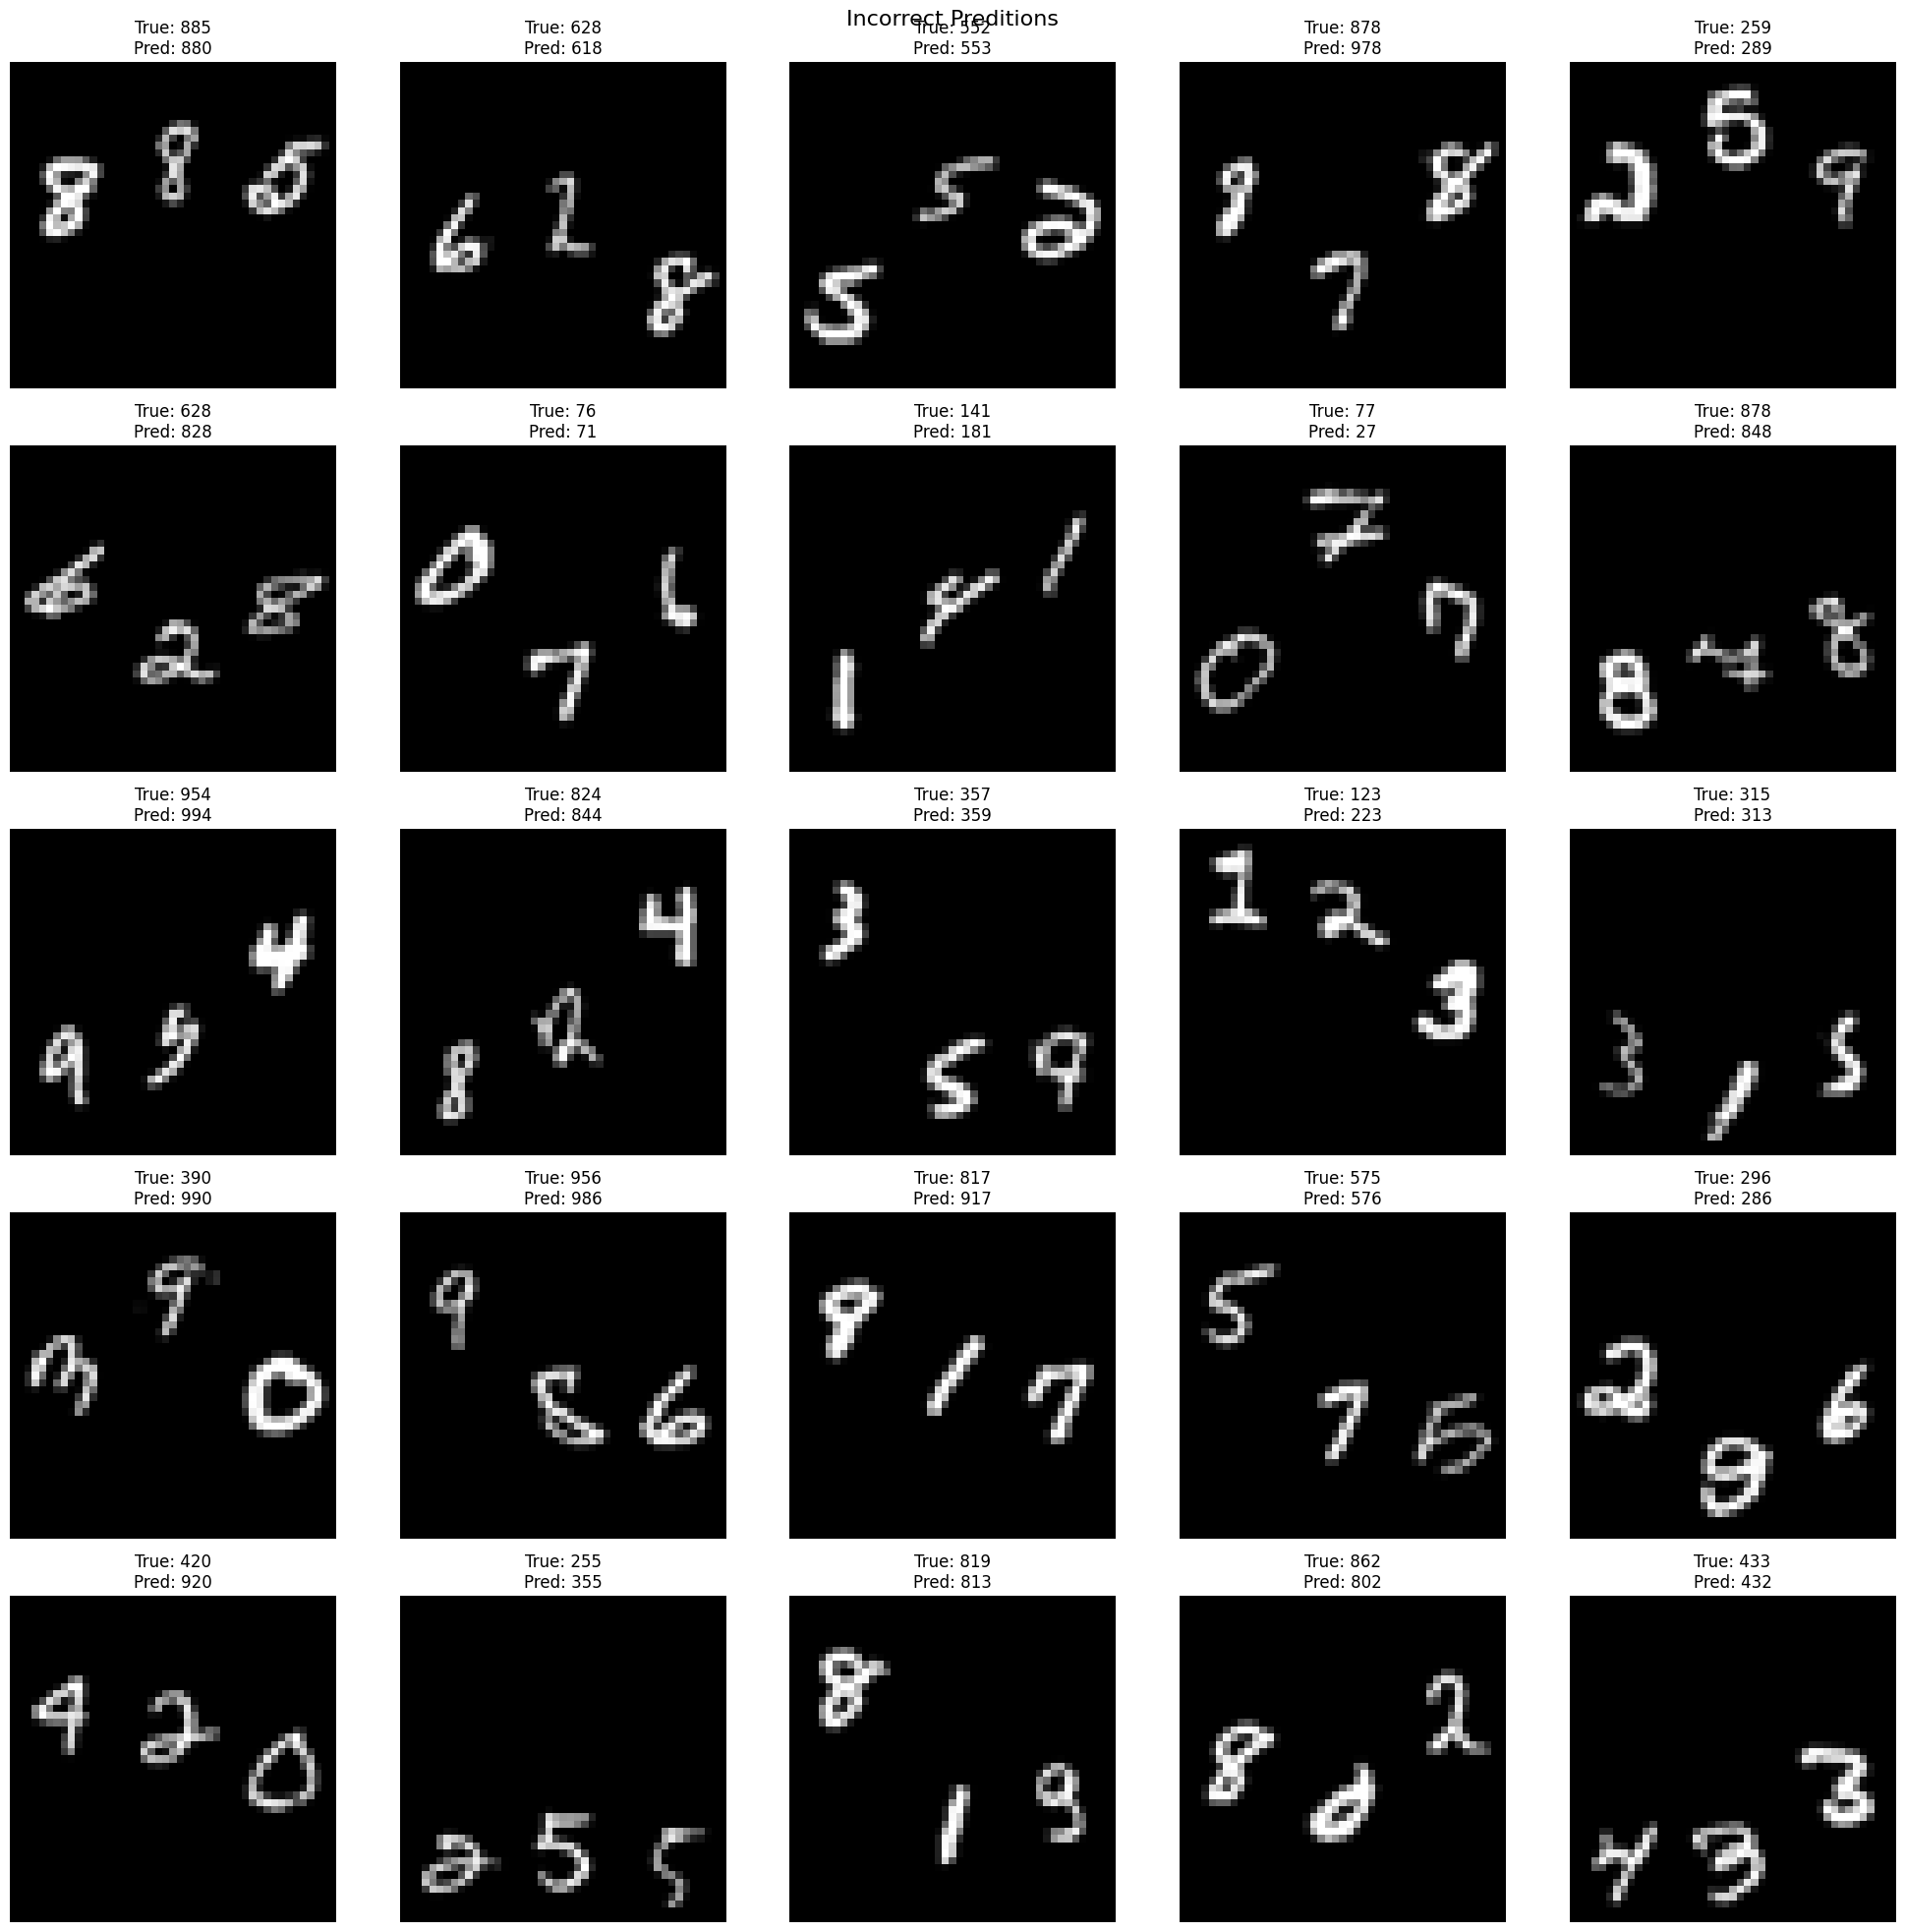

In [21]:
show_label_preds(False, test_imgs, test_labels, b_predicted_labels_combined)

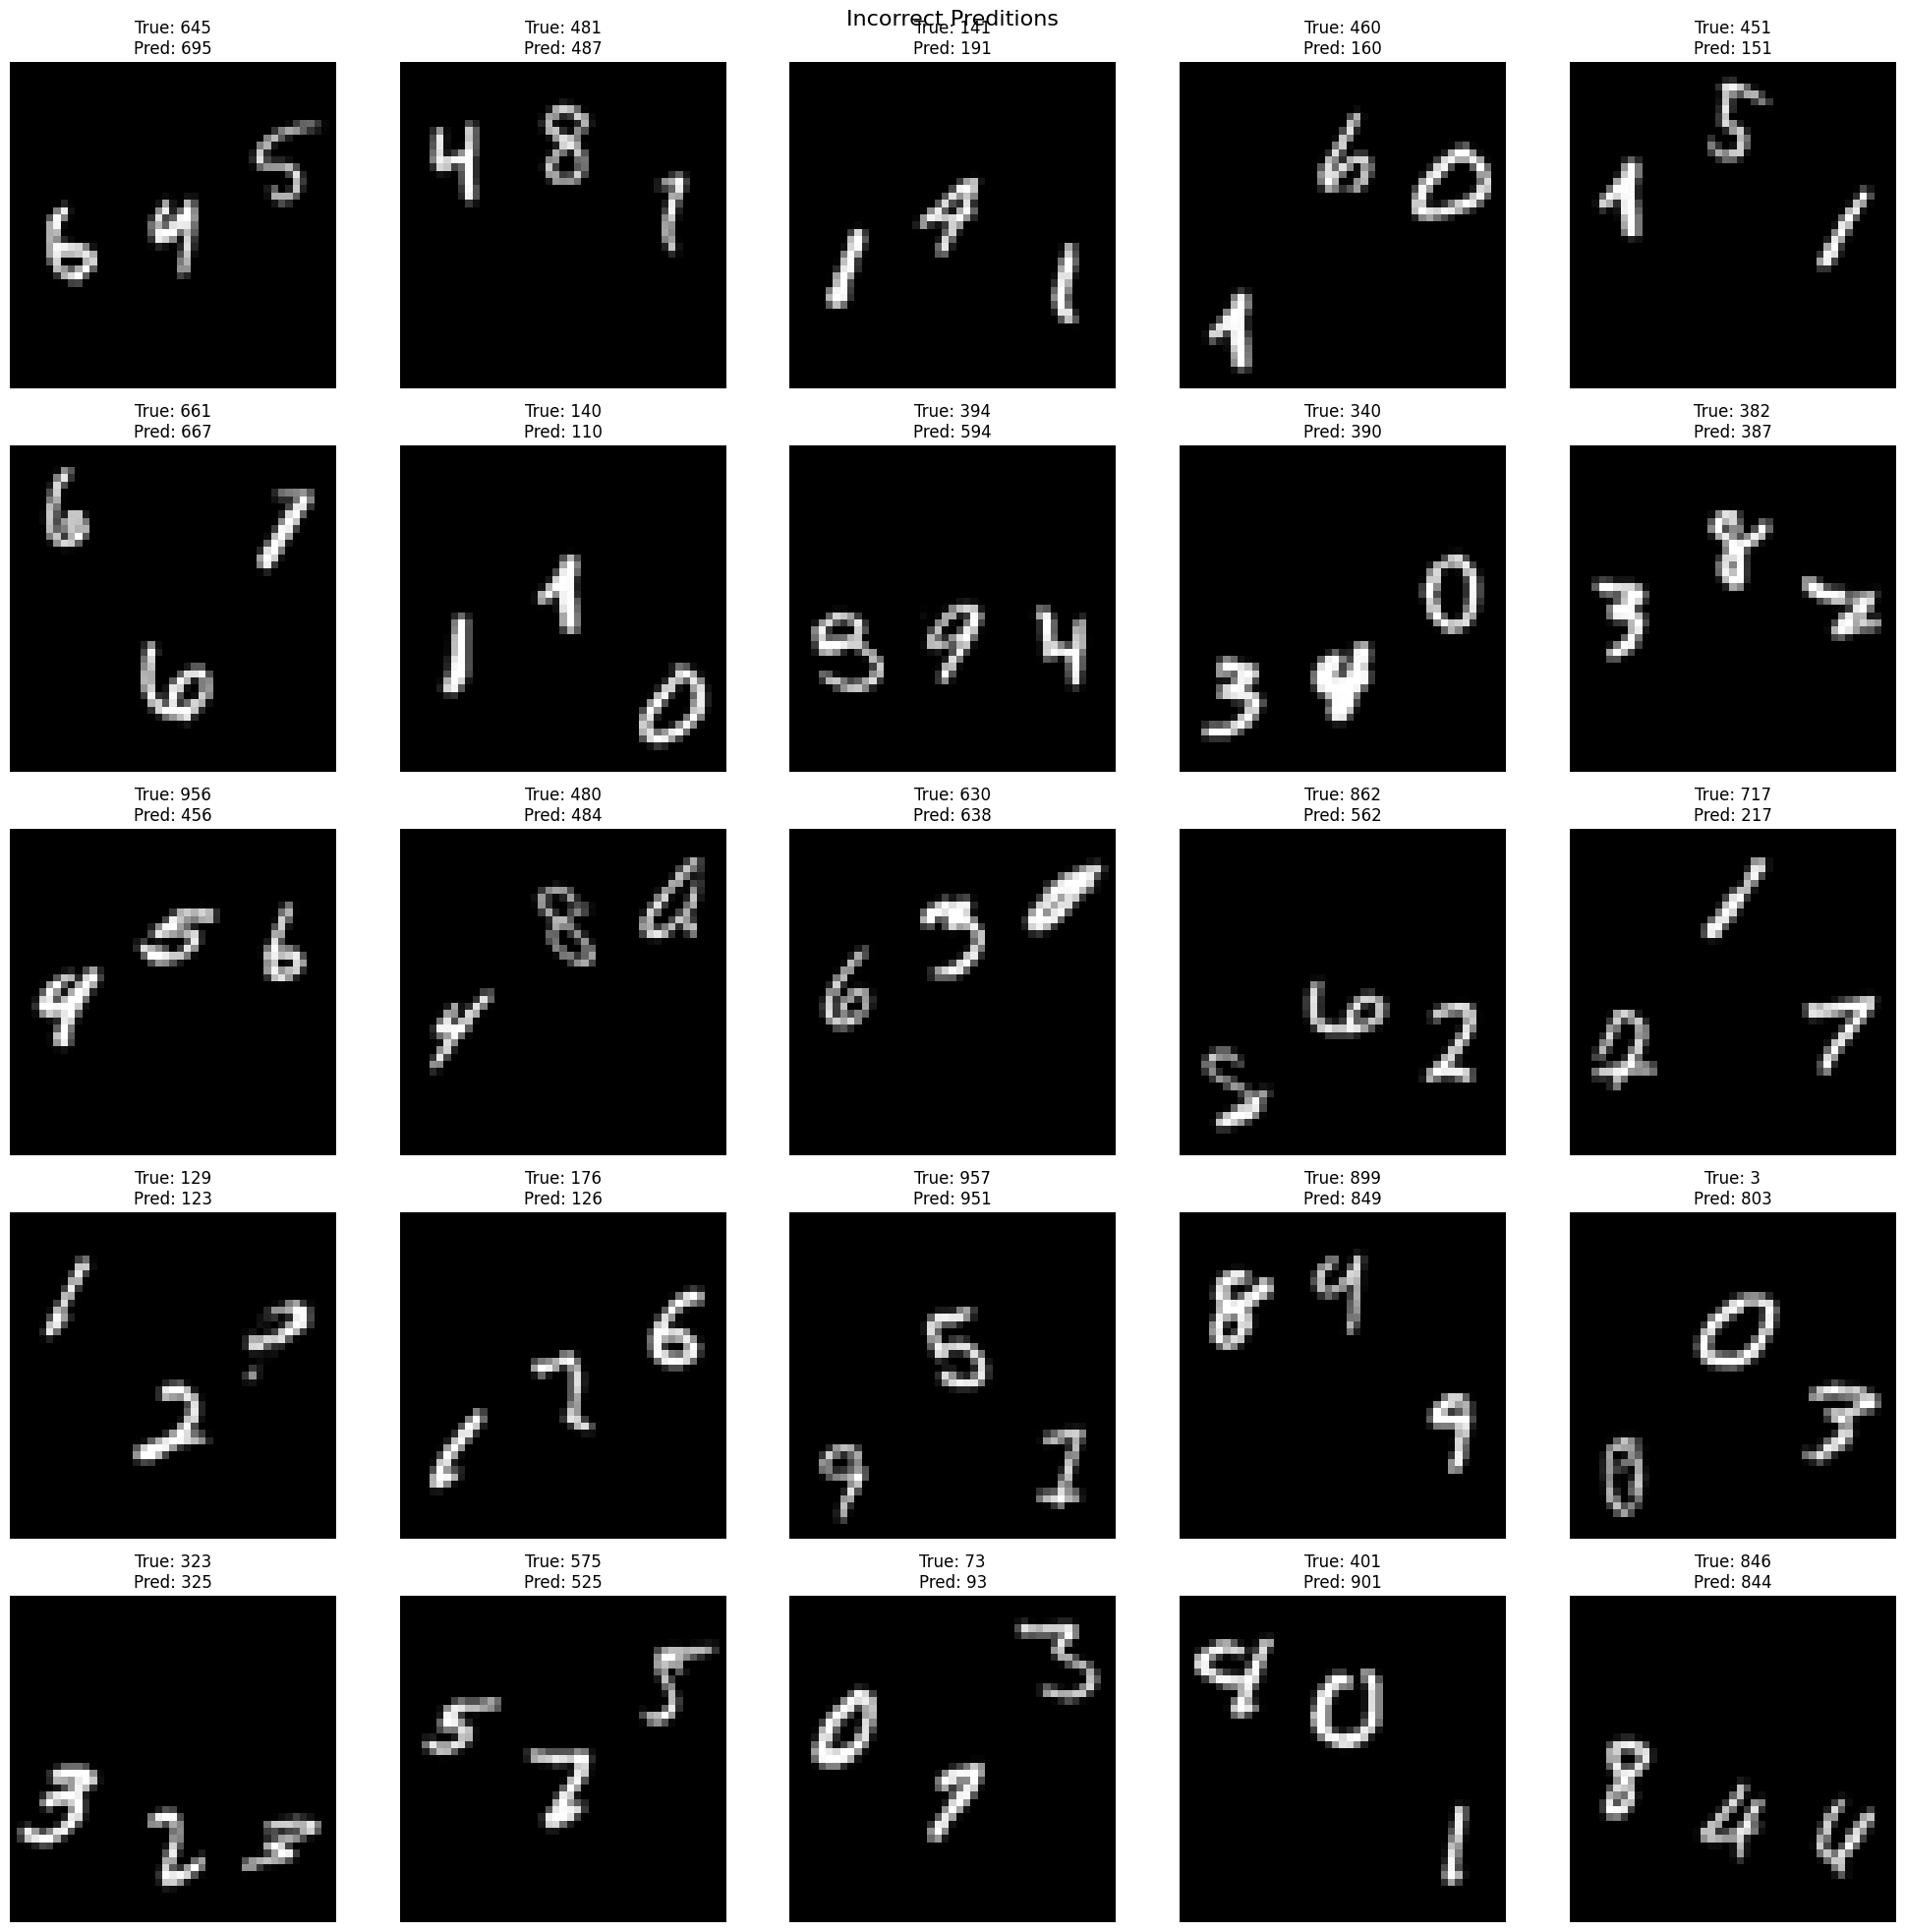

In [88]:
show_label_preds(False, test_imgs, test_labels, predicted_labels_combined)

Accuracy: 0.9145
F1 Score (Macro Average): 0.2424


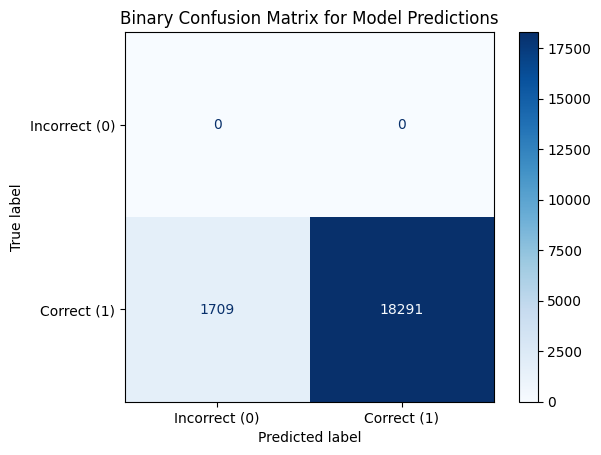

Accuracy: 0.9707
F1 Score (Macro Average): 0.9706
# Correct Predictions: 58244
# Incorrect Predictions: 1756


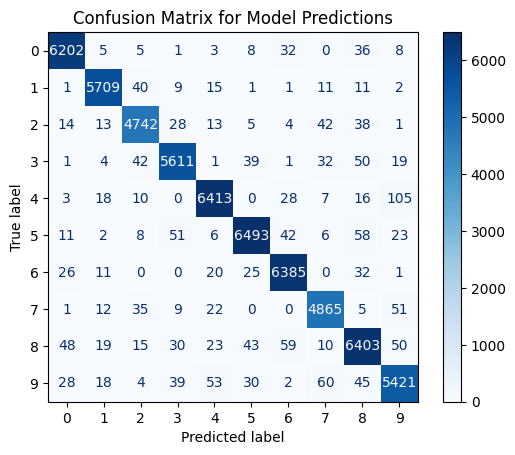

Basic model - digit 1
Accuracy: 0.9702
F1 Score (Macro Average): 0.9692
# Correct Predictions: 19404
# Incorrect Predictions: 596


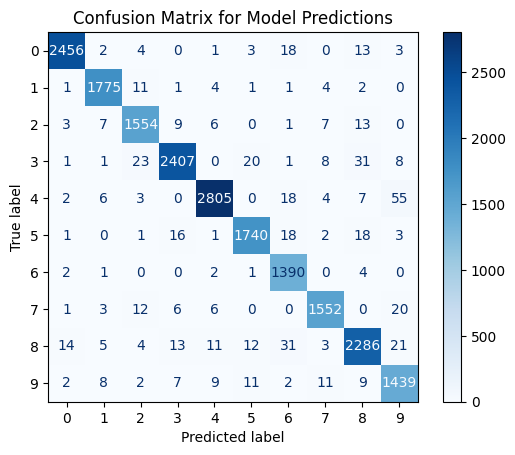

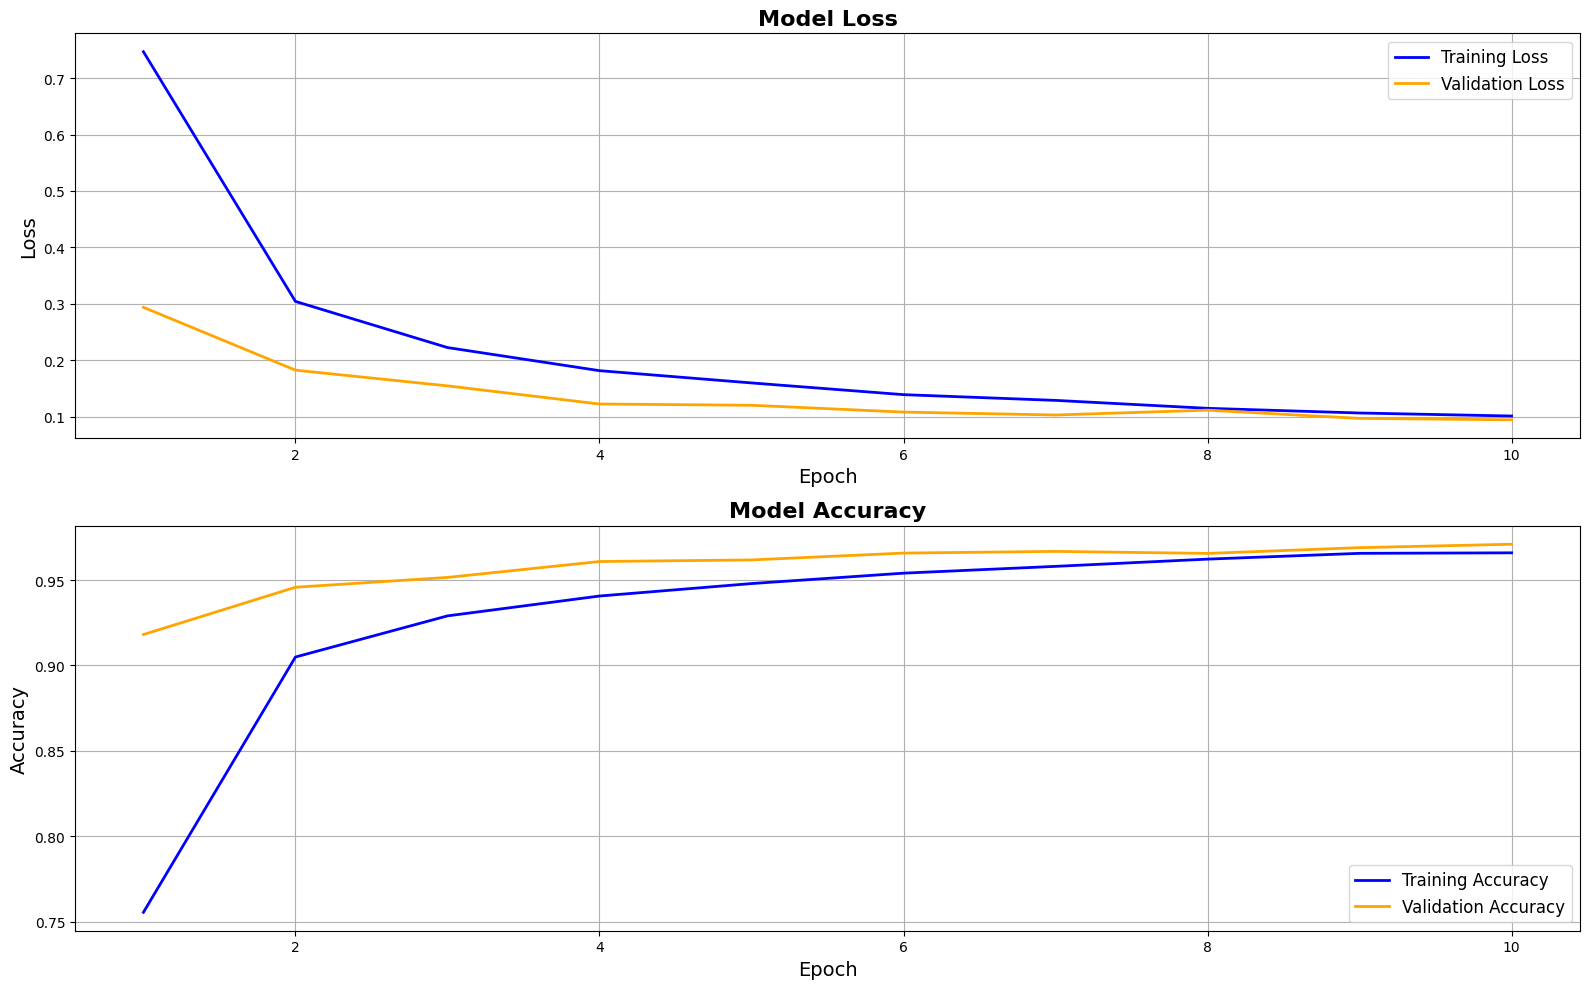

Basic model - digit 2
Accuracy: 0.9709
F1 Score (Macro Average): 0.9706
# Correct Predictions: 19419
# Incorrect Predictions: 581


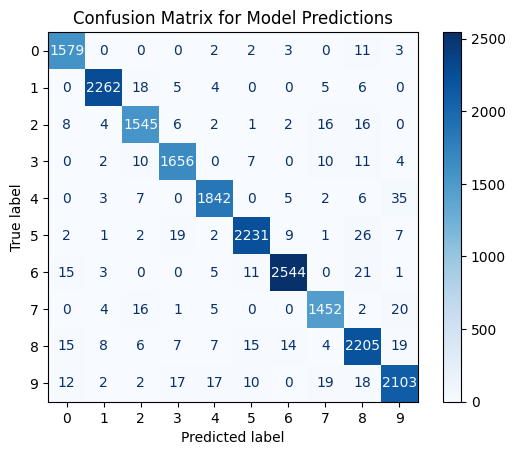

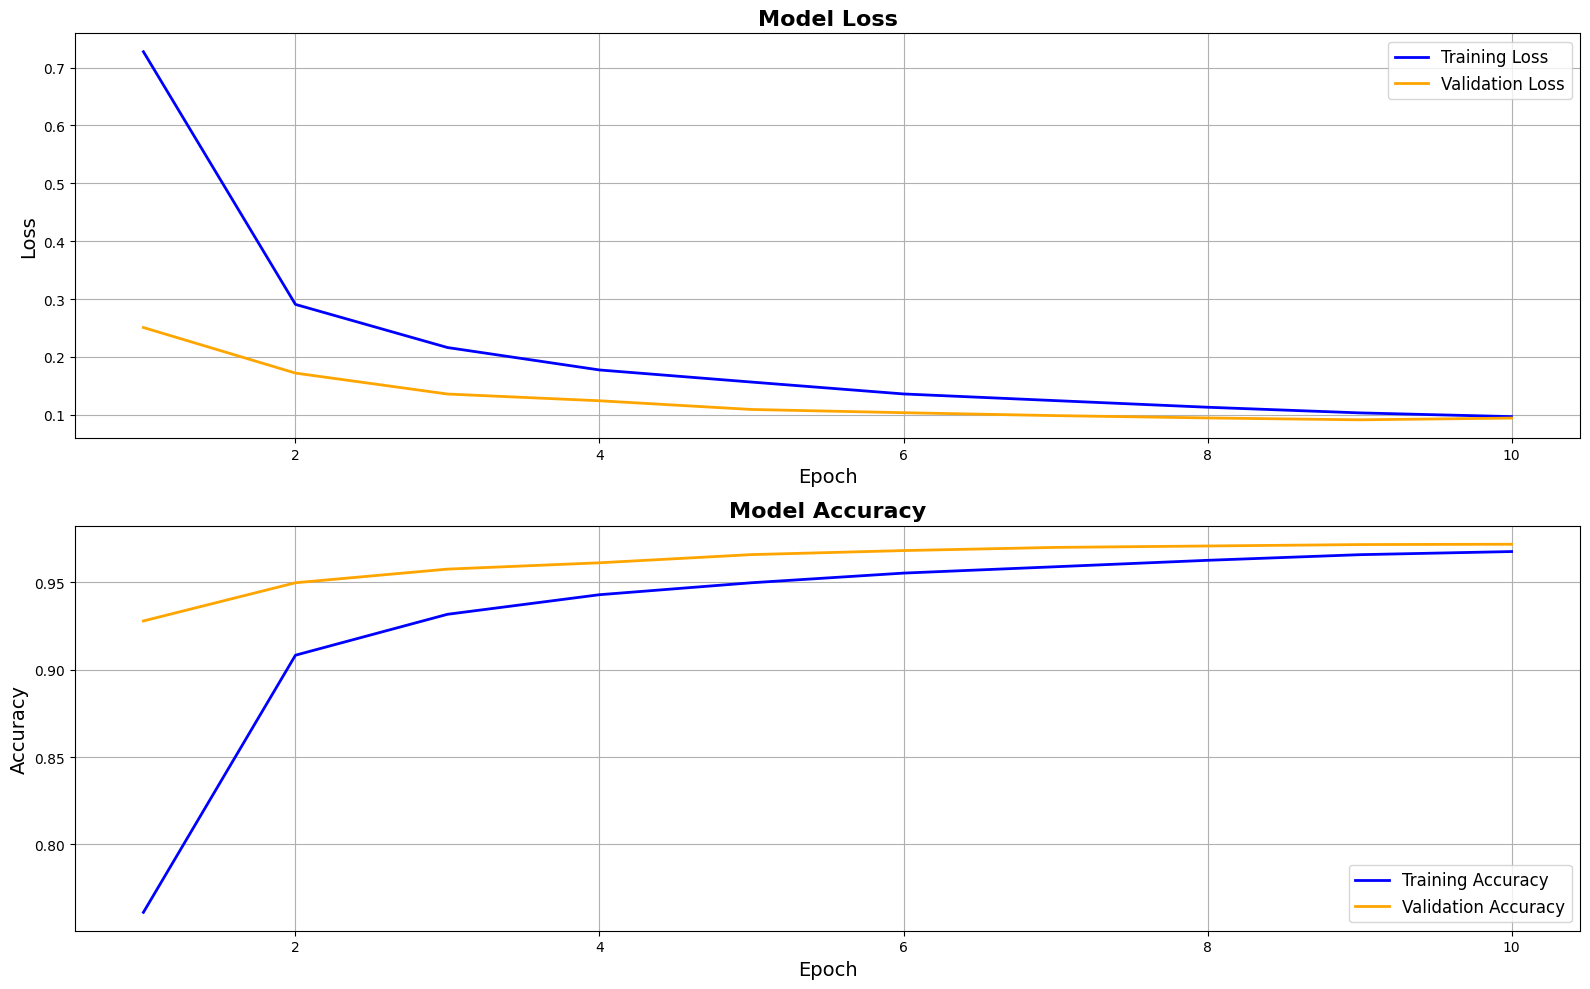

Basic model - digit 3
Accuracy: 0.9710
F1 Score (Macro Average): 0.9706
# Correct Predictions: 19421
# Incorrect Predictions: 579


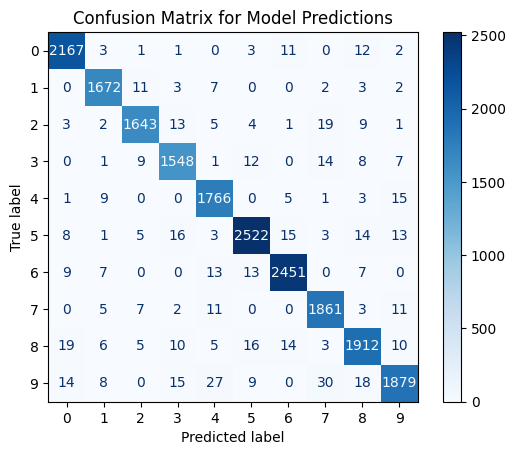

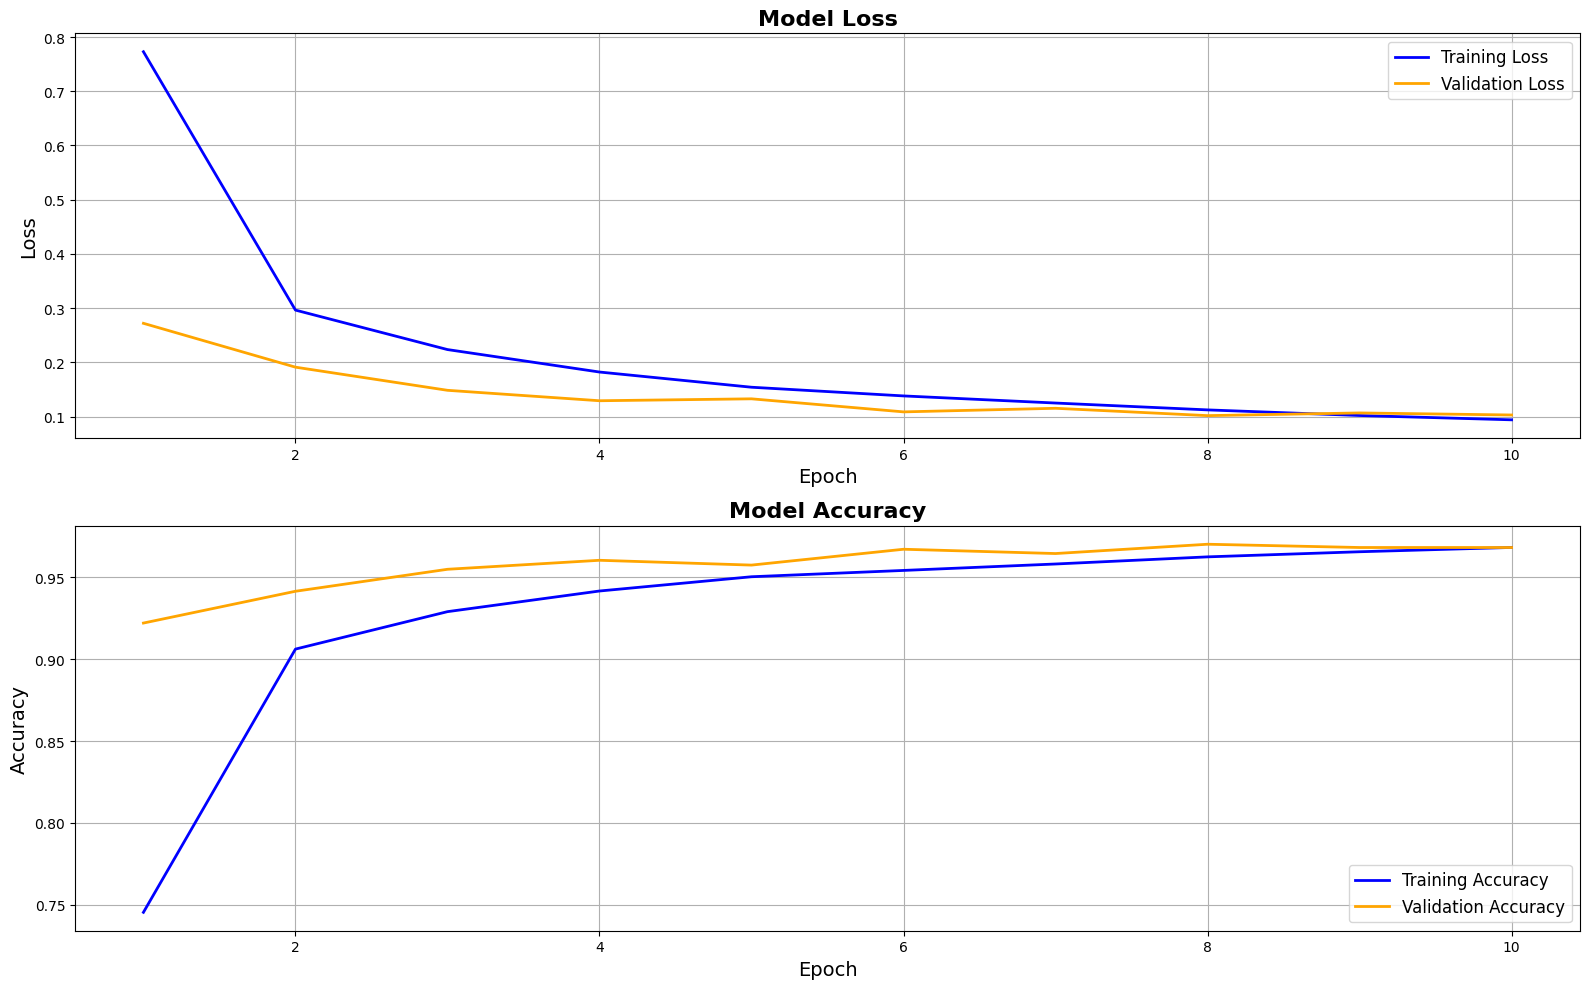

In [51]:
print ("Total stats")
get_stats(b_predicted_labels_combined, test_labels)

print ("ALL INDIVIDUAL DIGITS")
get_stats([int(digit) for num in b_predicted_labels_combined for digit in f"{num:03d}"], t_test_labels)

for i in range(len(b_t_models)):
    print(f"Basic model - digit {i+1}")
    get_stat_history(b_all_preds[:, i], t_test_labels[i::3], b_histories[i])

Total stats
Accuracy: 0.9699
F1 Score (Macro Average): 0.3979


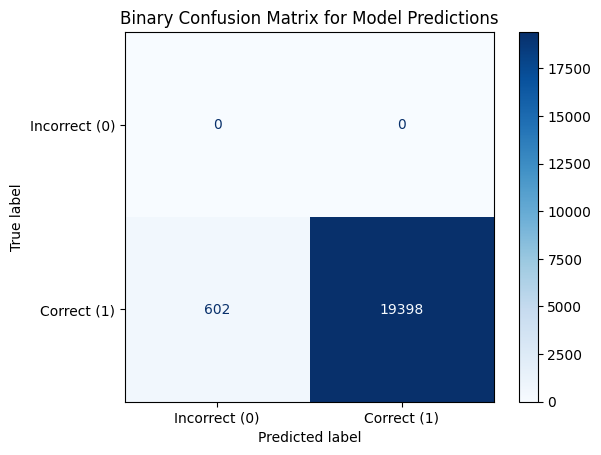

ALL INDIVIDUAL DIGITS
Accuracy: 0.9898
F1 Score (Macro Average): 0.9897
# Correct Predictions: 59389
# Incorrect Predictions: 611


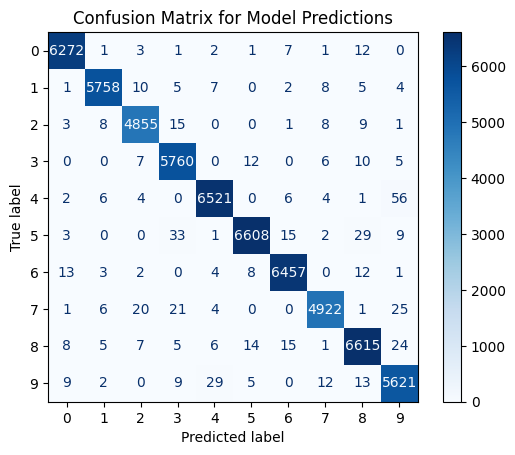

Complex model - digit 1
Accuracy: 0.9875
F1 Score (Macro Average): 0.9870
# Correct Predictions: 19750
# Incorrect Predictions: 250


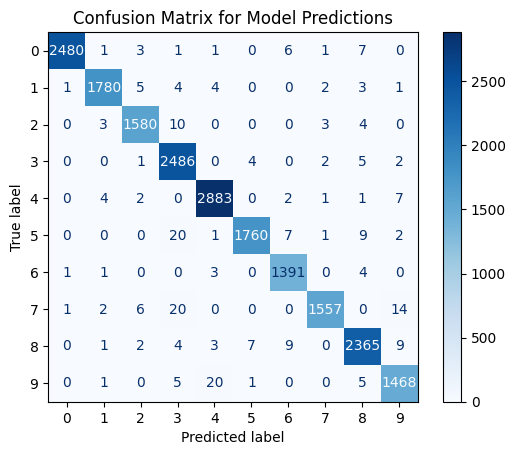

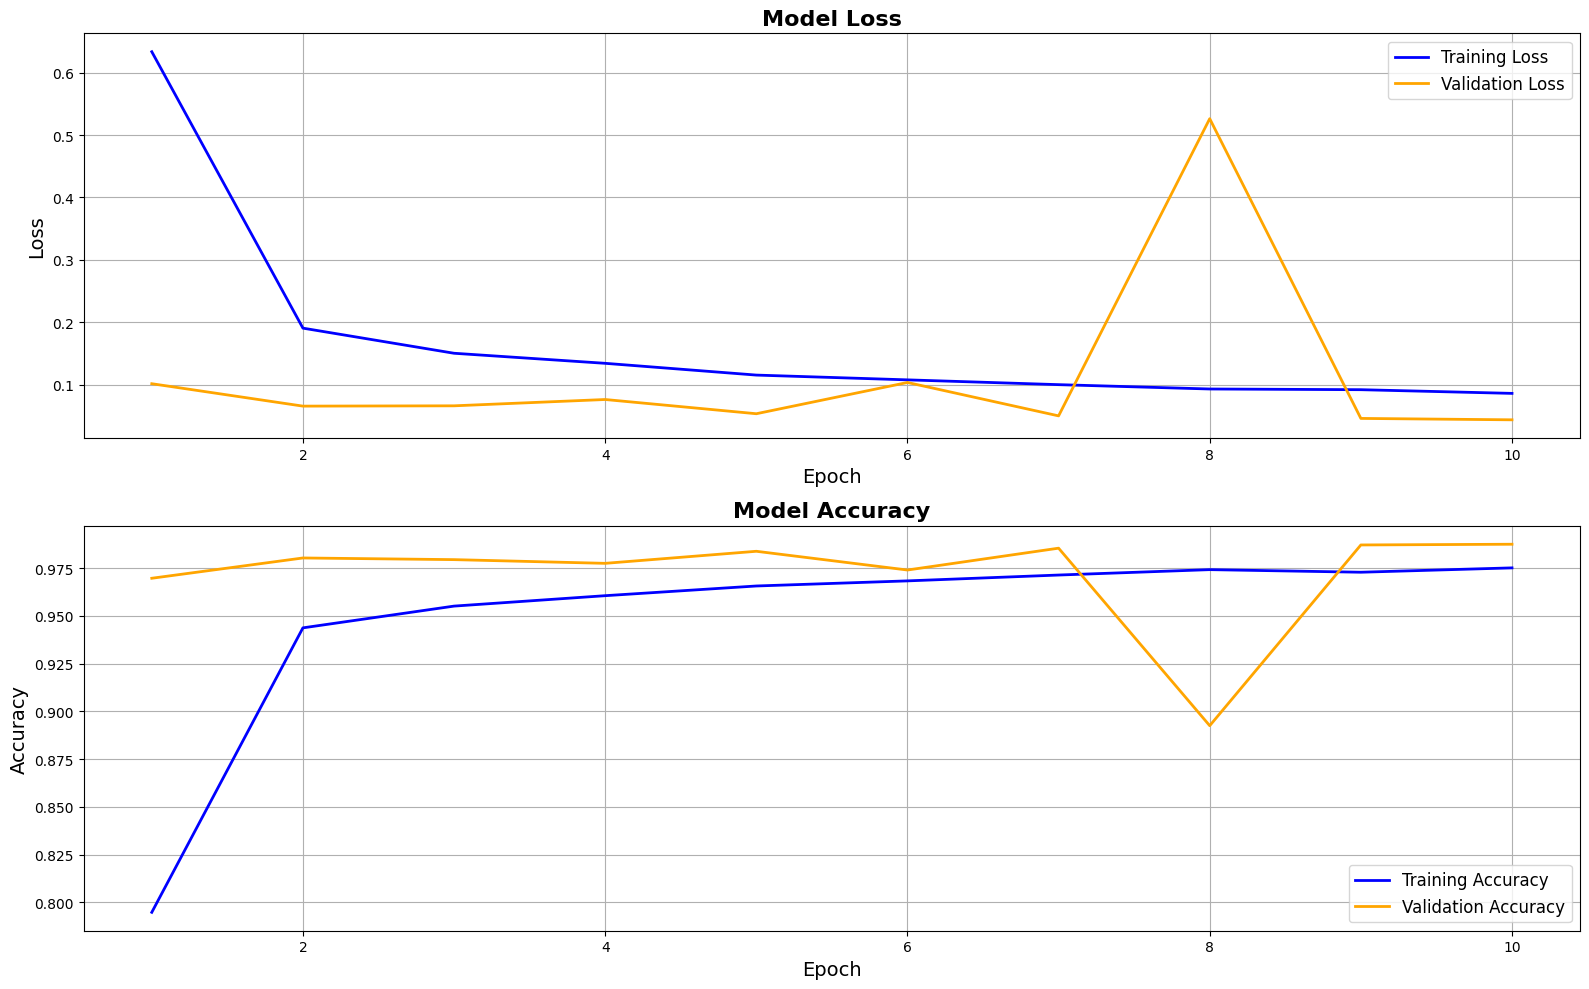

Complex model - digit 2
Accuracy: 0.9878
F1 Score (Macro Average): 0.9877
# Correct Predictions: 19756
# Incorrect Predictions: 244


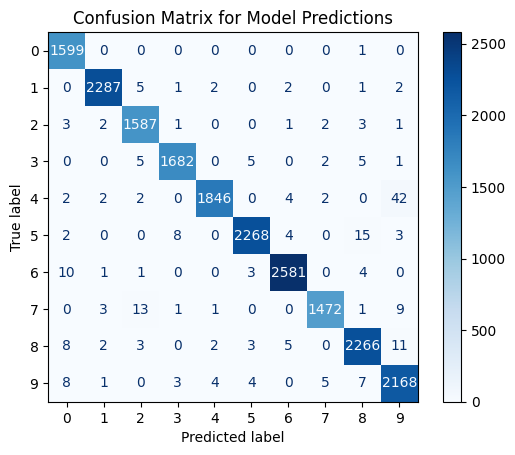

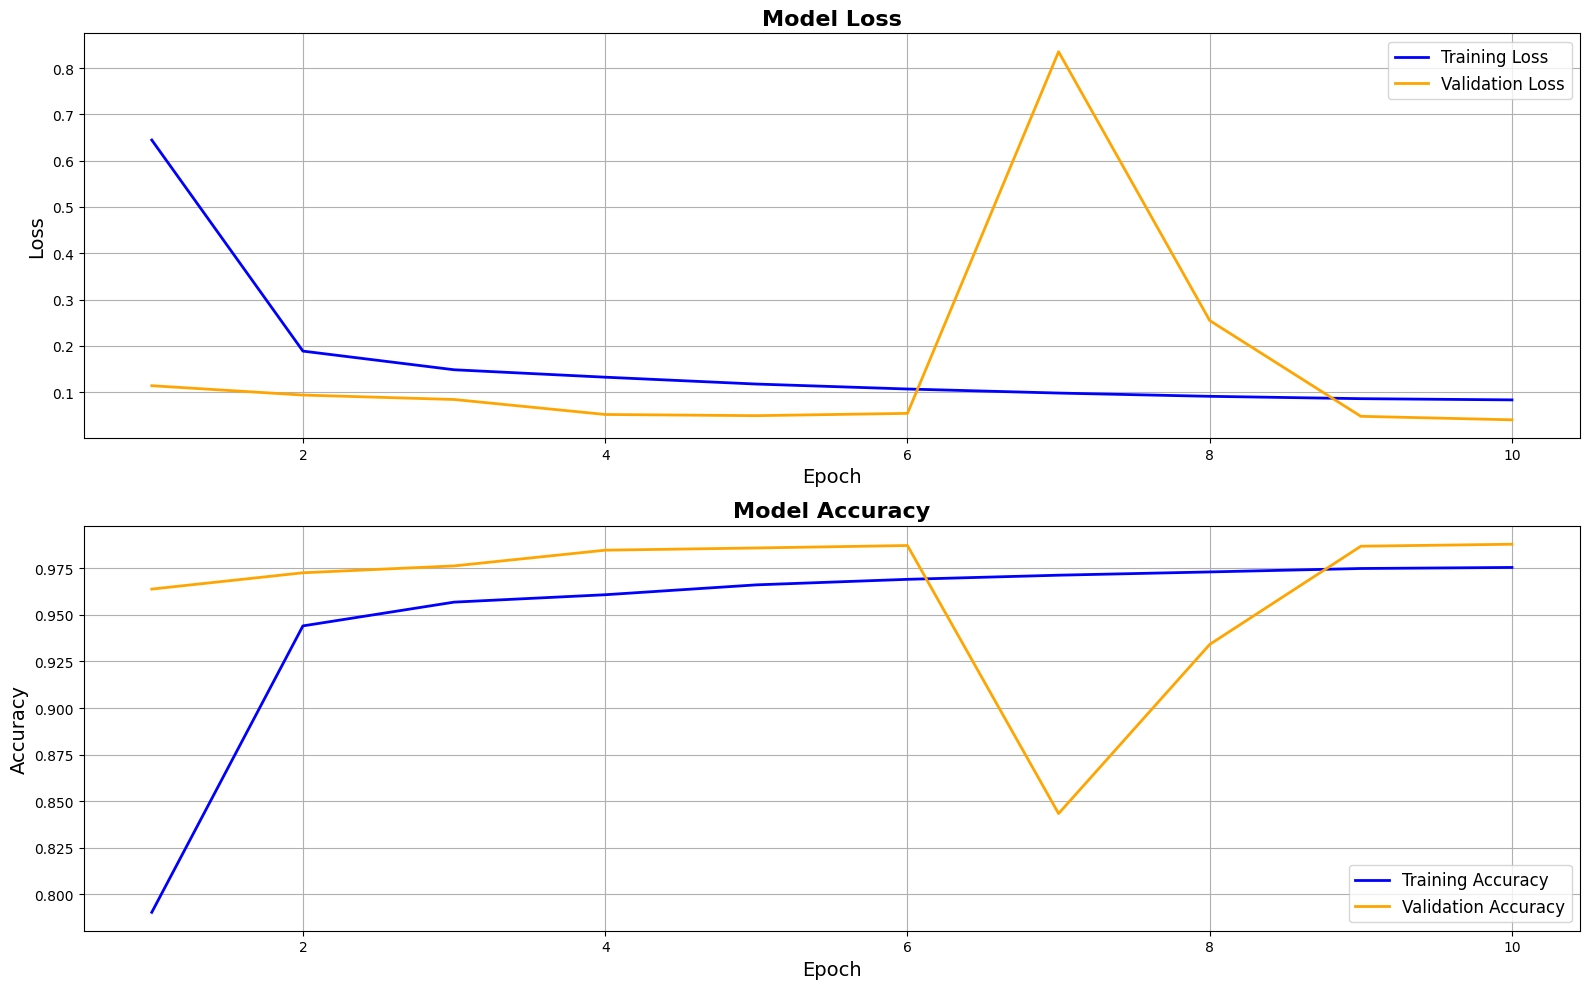

Complex model - digit 3
Accuracy: 0.9941
F1 Score (Macro Average): 0.9941
# Correct Predictions: 19883
# Incorrect Predictions: 117


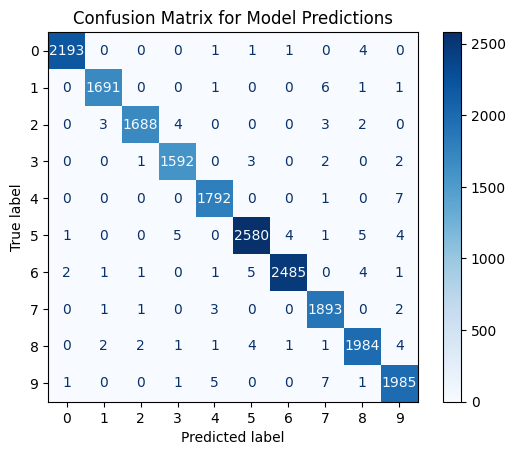

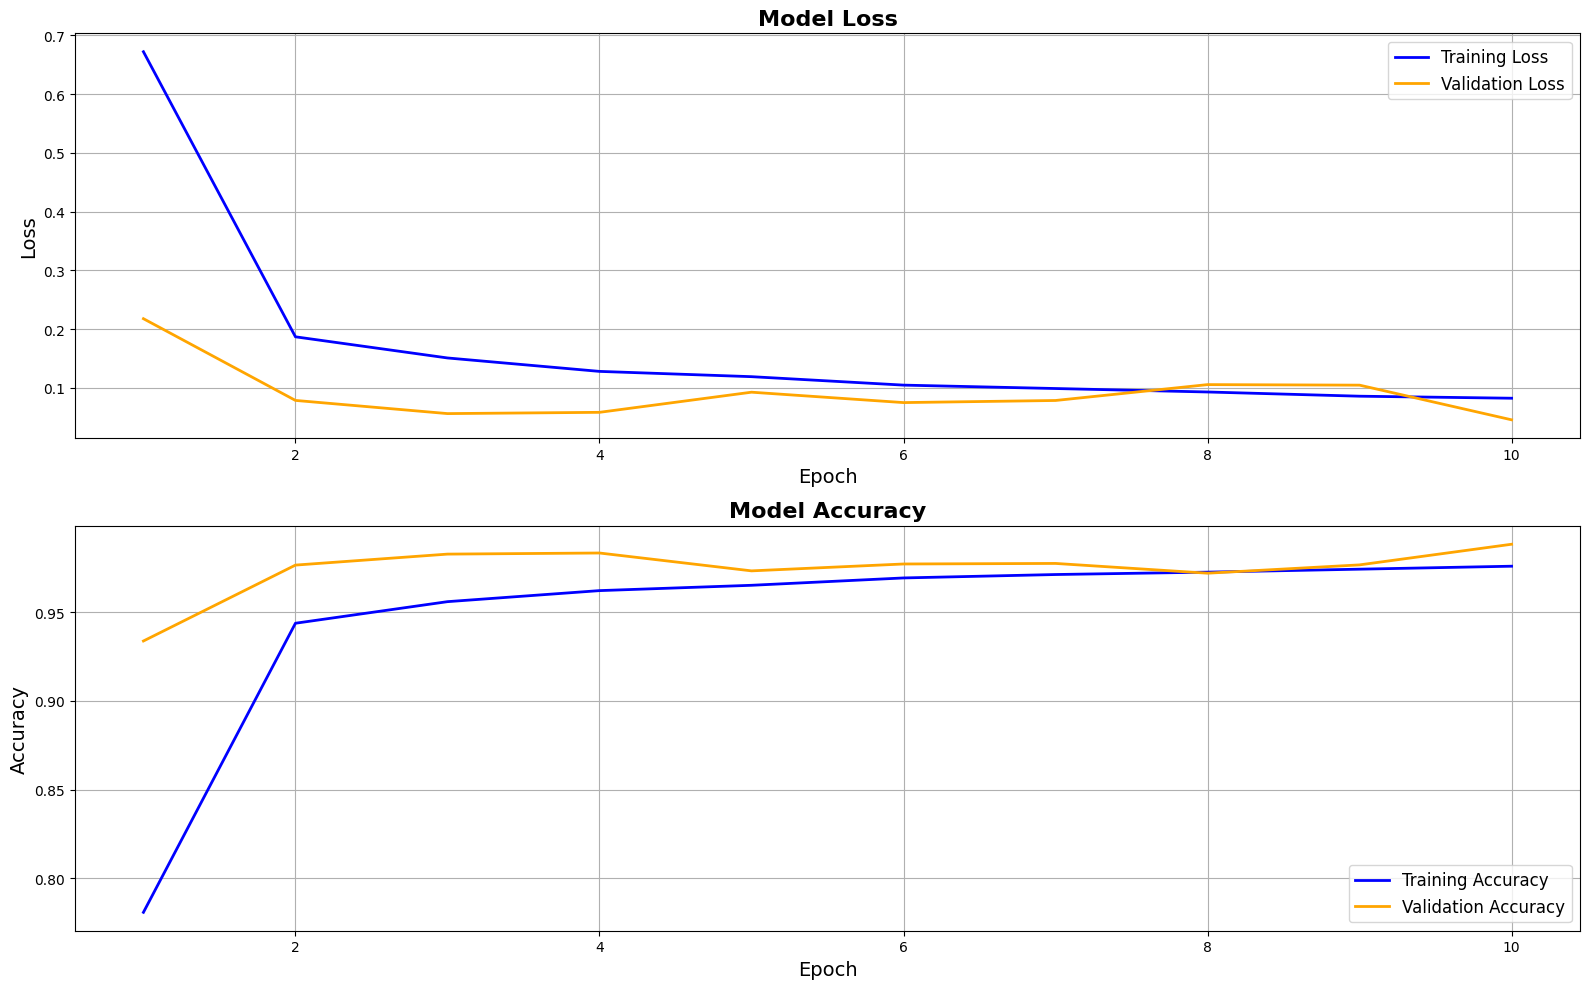

In [84]:
print ("Total stats")
get_stats(predicted_labels_combined, test_labels)

print ("ALL INDIVIDUAL DIGITS")
get_stats([int(digit) for num in predicted_labels_combined for digit in f"{num:03d}"], t_test_labels)


for i in range(len(t_models)):
    print(f"Complex model - digit {i+1}")
    get_stat_history(all_preds[:, i], t_test_labels[i::3], histories[i])

Accuracy: 0.9480
F1 Score (Macro Average): 0.2892


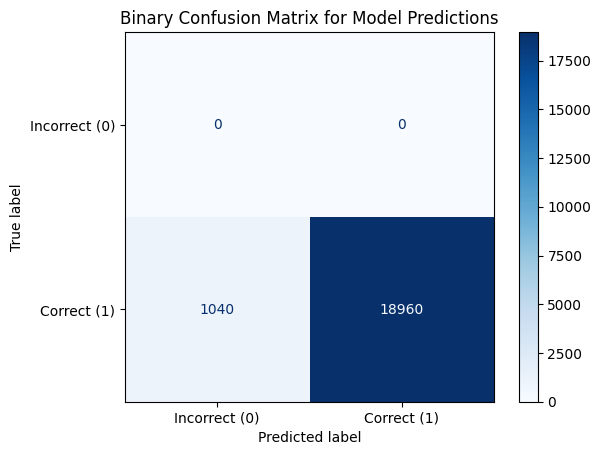

Accuracy: 0.9823
F1 Score (Macro Average): 0.9823
# Correct Predictions: 58938
# Incorrect Predictions: 1062


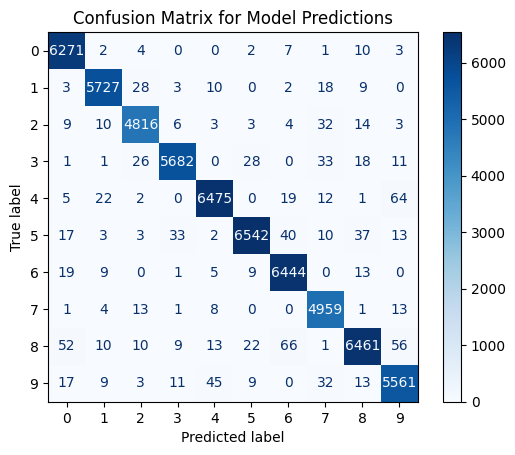

Complex2 model - digit 1
Accuracy: 0.9807
F1 Score (Macro Average): 0.9800
# Correct Predictions: 19614
# Incorrect Predictions: 386


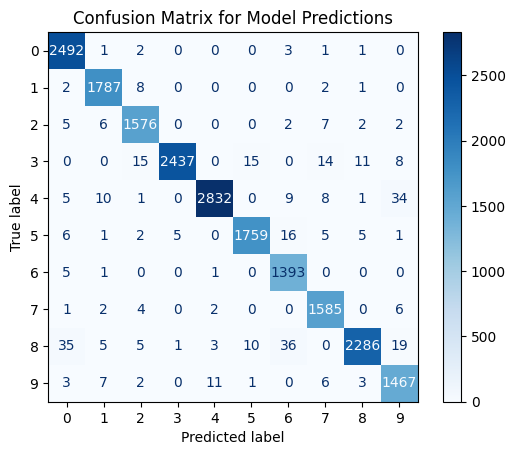

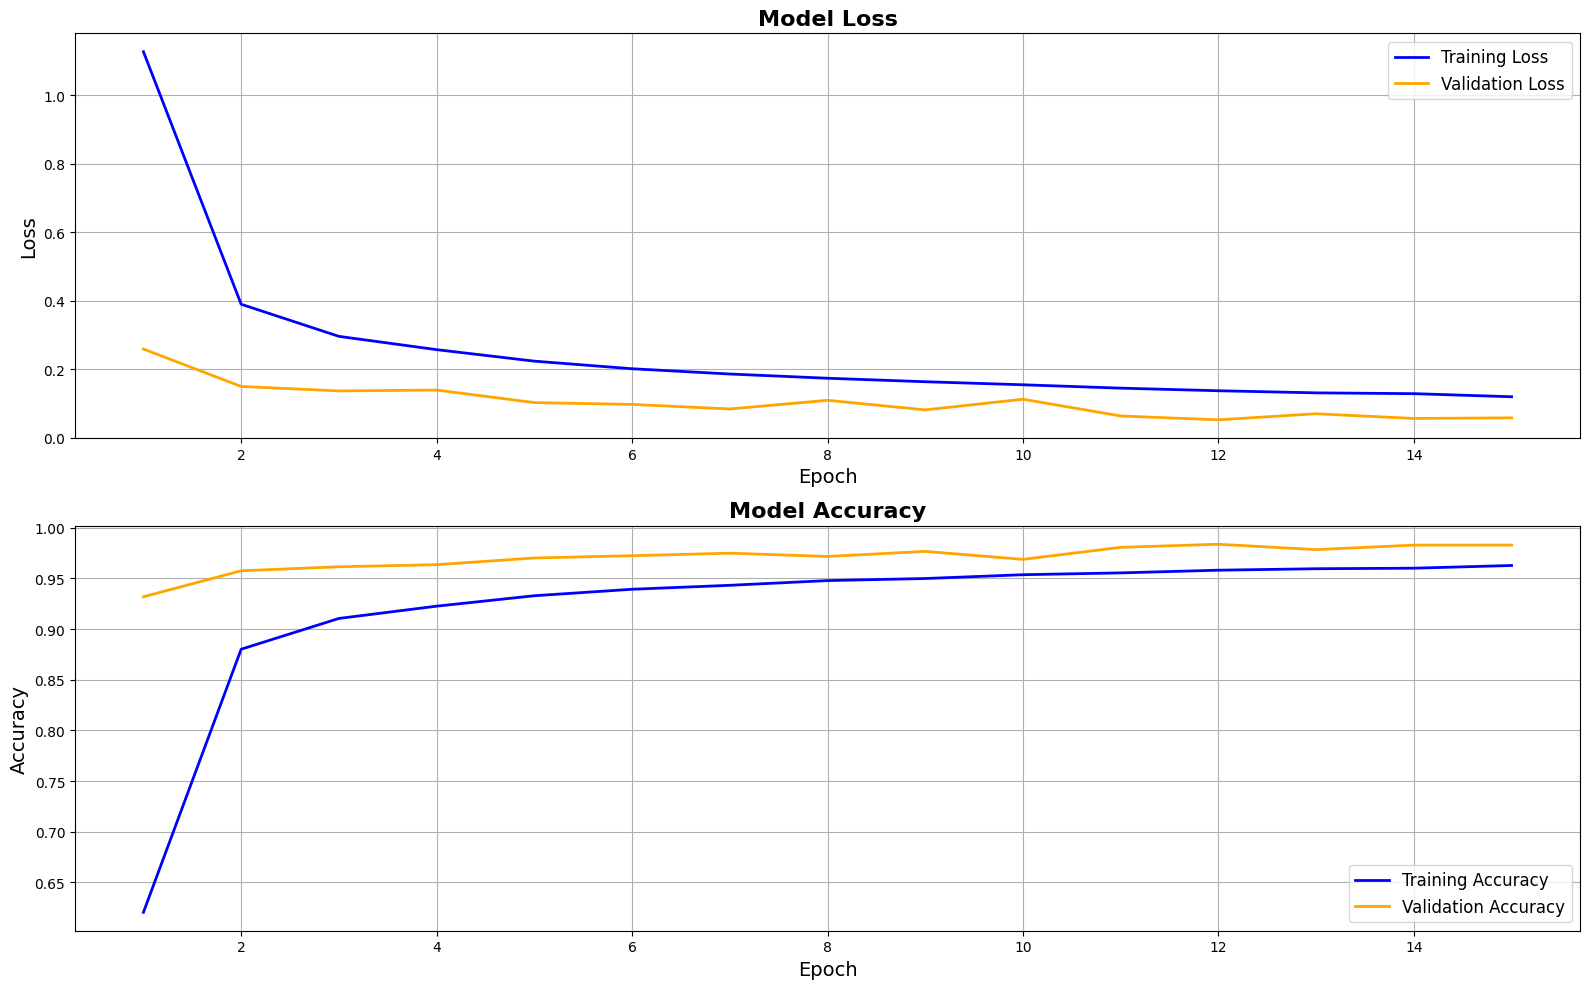

Complex2 model - digit 2
Accuracy: 0.9830
F1 Score (Macro Average): 0.9830
# Correct Predictions: 19661
# Incorrect Predictions: 339


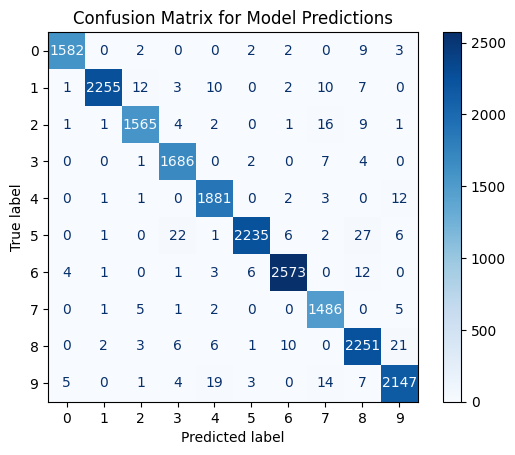

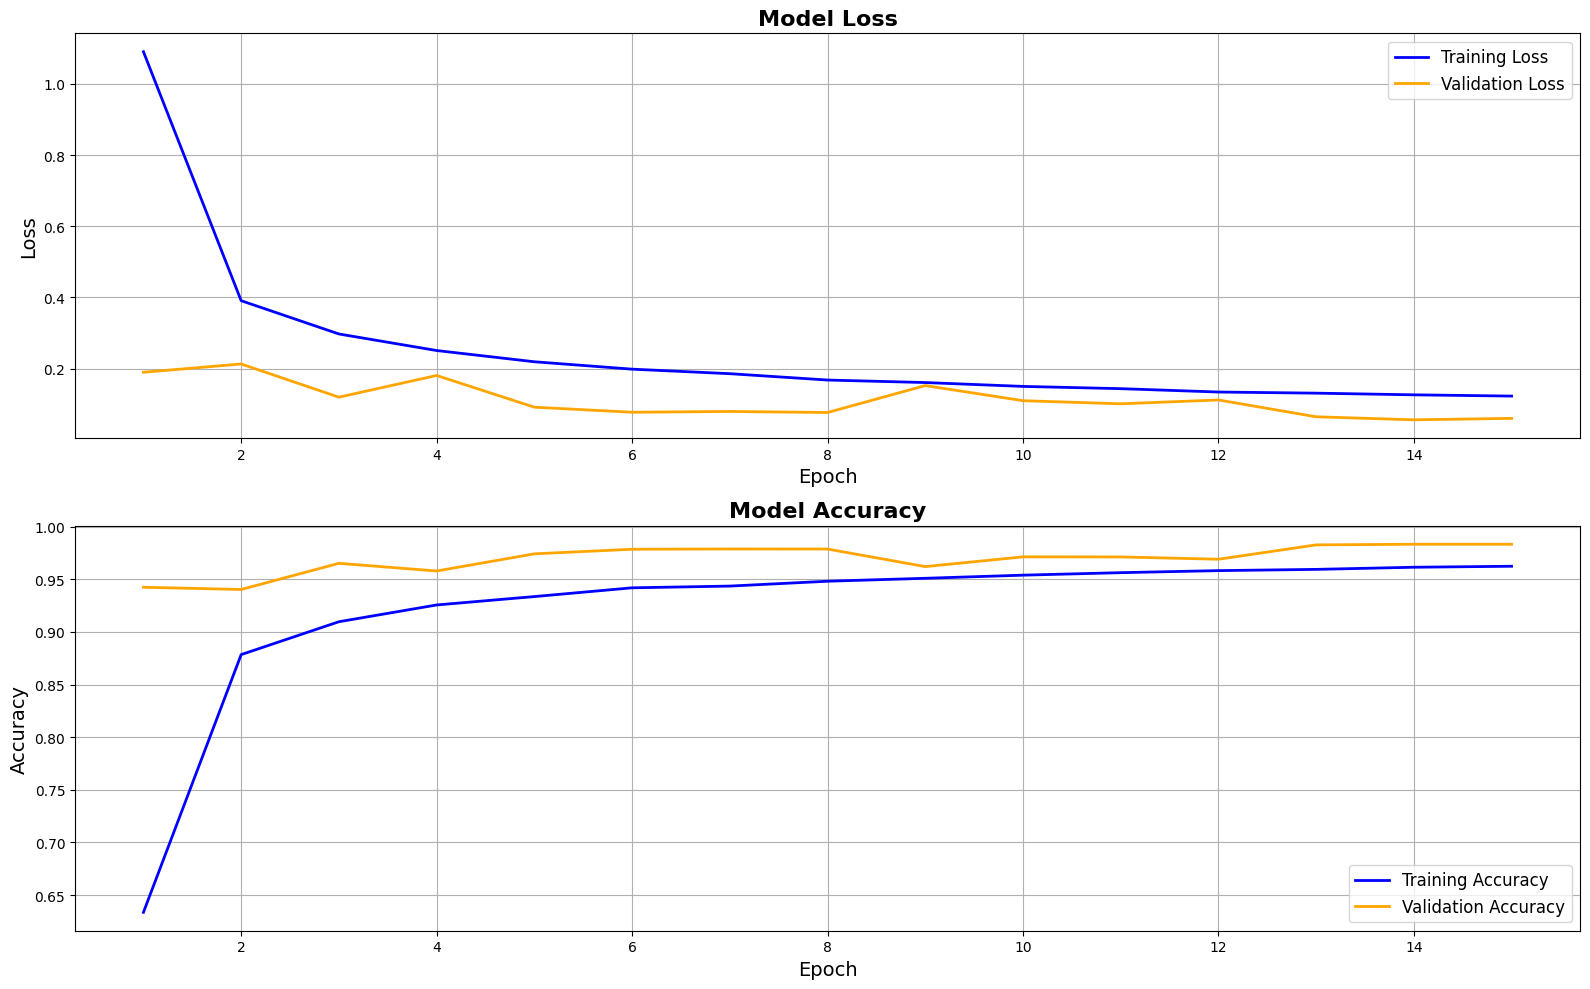

Complex2 model - digit 3
Accuracy: 0.9831
F1 Score (Macro Average): 0.9831
# Correct Predictions: 19663
# Incorrect Predictions: 337


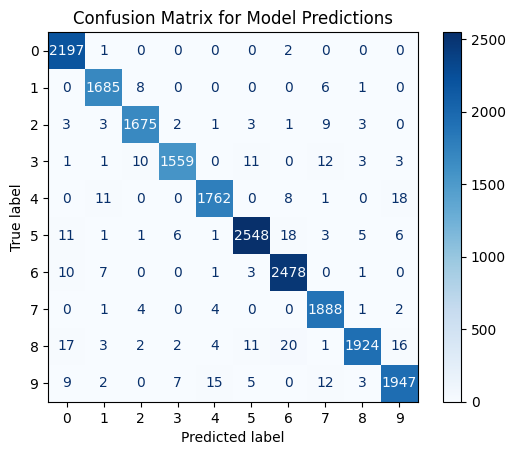

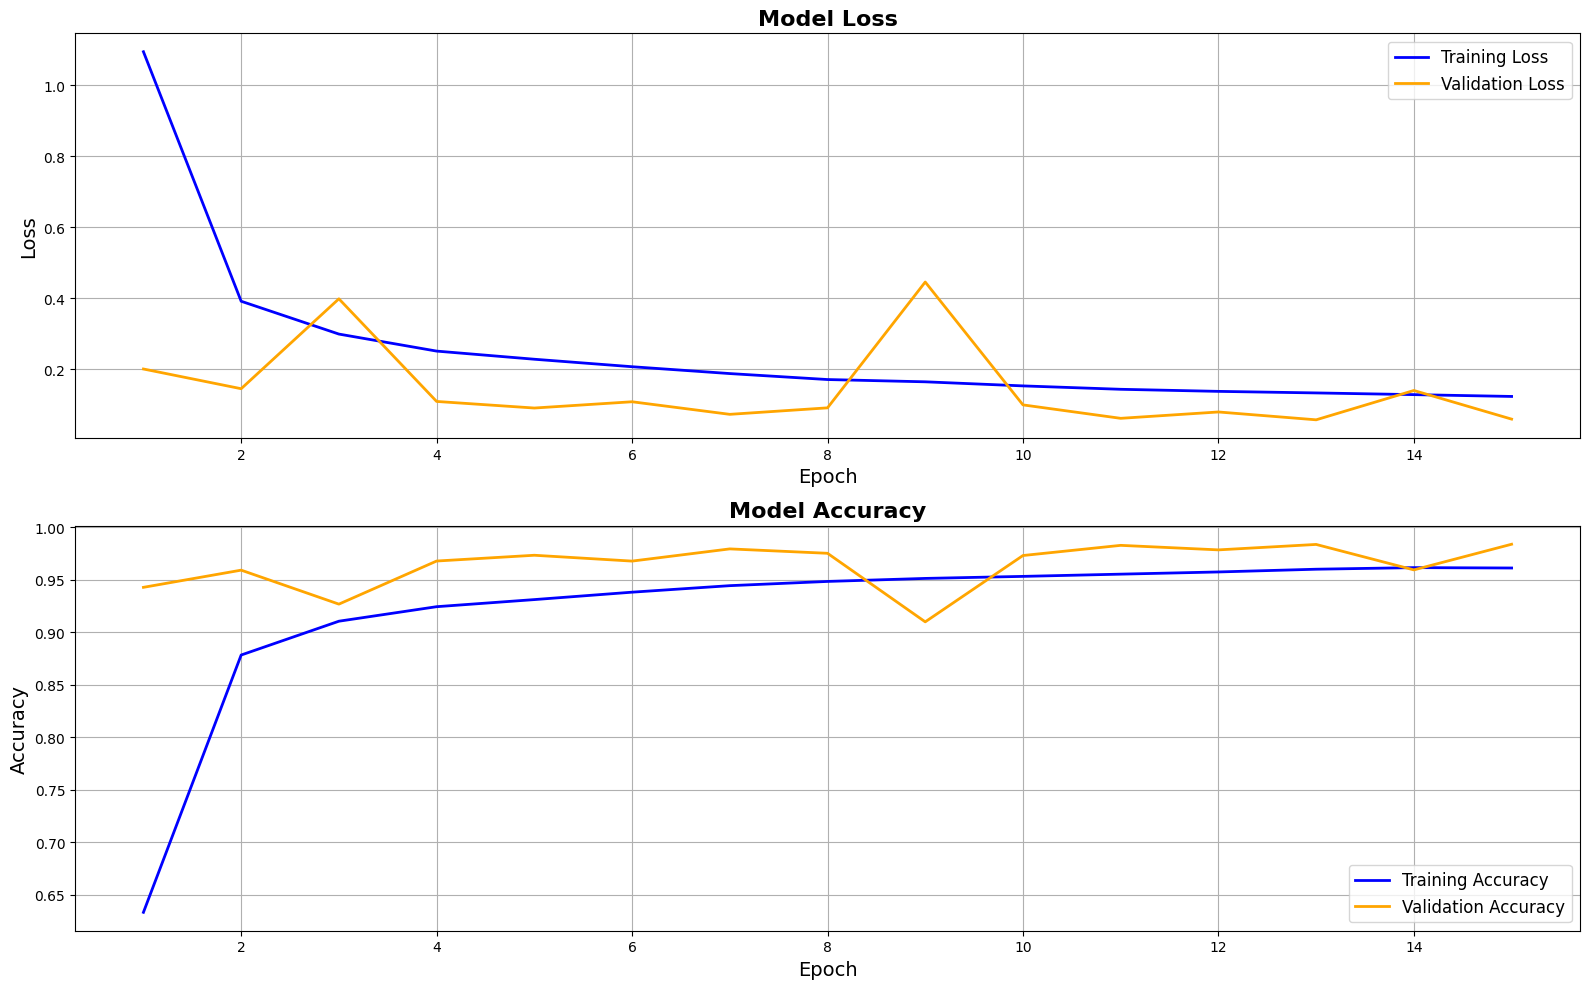

In [87]:
get_stats(predicted_labels_combined2, test_labels)
get_stats([int(digit) for num in predicted_labels_combined2 for digit in f"{num:03d}"], t_test_labels)

for i in range(len(t_models2)):
    print(f"Complex2 model - digit {i+1}")
    get_stat_history(all_preds2[:, i], t_test_labels[i::3], histories2[i])

In [ ]:
# Define the data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,         # Random rotation between 0 and 15 degrees
    width_shift_range=0.1,     # Random horizontal shifts
    height_shift_range=0.1,    # Random vertical shifts
    shear_range=0.1,           # Shear transformations
    zoom_range=0.1,            # Random zoom
    horizontal_flip=True,      # Random horizontal flips
    fill_mode='nearest'        # Filling strategy for newly created pixels
)

# Assuming `train_images` is your training data (numpy array) and is normalized
# Reshape images if necessary to include the channel dimension (e.g., (batch_size, height, width, channels))
# Example: train_images = train_images.reshape(-1, 45, 15, 1)

# Fit the data generator on the training data (useful for datasets with normalization or whitening)
datagen.fit(train_image)

# Example of generating augmented data for training
batch_size = 32
augmented_data = datagen.flow(train_images, train_labels, batch_size=batch_size)

# Train the model using the augmented data generator
model.fit(
    augmented_data,
    validation_data=(val_images, val_labels),
    epochs=50,
    steps_per_epoch=len(train_images) // batch_size
)
